## Installation

In [1]:
!pip install opencv-python

In [2]:
!pip install tensorflow-hub

## Setup

In [3]:
import pandas as pd
import numpy as np
import cv2
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D
from keras.layers import Input, Activation, LeakyReLU, Dropout
from keras.losses import BinaryCrossentropy
try:
    from keras.optimizer import Adam
except:
    from tensorflow.keras.optimizers import Adam
    
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator


from sklearn.metrics import classification_report, confusion_matrix

## Importing Dataset

In [4]:
import warnings
warnings.filterwarnings('ignore')

MAIN_DIR = "D:/Assignment/brain_tumor_dataset/"

## Data Loading,Preparation and Visualization

In [5]:
os.listdir(MAIN_DIR)

['no', 'yes']

In [6]:
for dirpath,dirnames,filenames in os.walk(MAIN_DIR):
    print(f"{len(dirnames)} directories and {len(filenames)} images in {dirpath}")

2 directories and 0 images in D:/Assignment/brain_tumor_dataset/
0 directories and 98 images in D:/Assignment/brain_tumor_dataset/no
0 directories and 155 images in D:/Assignment/brain_tumor_dataset/yes


In [7]:
# Inspect the raw data before preprocessing
def view_random_image():  
    subdirs = ['yes/','no/']
    subdir = np.random.choice(subdirs)
    target_folder = MAIN_DIR + subdir
    
    random_image = random.sample(os.listdir(target_folder), 1)
    
    img = cv2.imread(target_folder+random_image[0])
    plt.imshow(img, cmap="gray")
    plt.axis(False)
    plt.title(img.shape)
    plt.show()

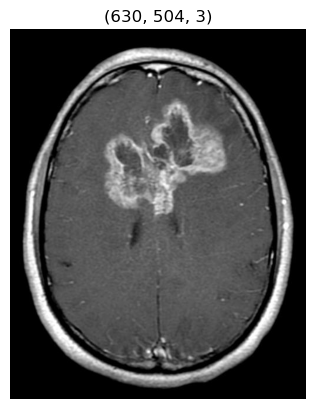

In [8]:
# View Random Image
view_random_image()

## Data Augmentation

In [9]:
# Resizing images
IMG_SHAPE = (128,128)
BATCH_SIZE = 32

In [10]:
# Define data augmentation parameters
datagen = ImageDataGenerator(
    rescale=1/255.0,
    validation_split=0.5,
    rotation_range=40,       # Randomly rotate the image by up to 40 degrees
    width_shift_range=0.2,   # Randomly shift the width by up to 20% of the image width
    height_shift_range=0.2,  # Randomly shift the height by up to 20% of the image height
    shear_range=0.2,         # Apply shearing transformations
    zoom_range=0.2,          # Randomly zoom in or out by up to 20%
    horizontal_flip=True,    # Randomly flip images horizontally
    fill_mode='nearest'      # Fill in new pixels with the nearest available pixel
)

train_data = datagen.flow_from_directory(MAIN_DIR,
                                        target_size=IMG_SHAPE,
                                        batch_size=BATCH_SIZE,
                                        class_mode="binary",
                                        shuffle=True,
                                        subset="training")

test_data = datagen.flow_from_directory(MAIN_DIR,
                                       target_size=IMG_SHAPE,
                                       batch_size=BATCH_SIZE,
                                       class_mode="binary",
                                       shuffle=True,
                                       subset="validation")

Found 127 images belonging to 2 classes.
Found 126 images belonging to 2 classes.


In [11]:
len(train_data), len(test_data)

(4, 4)

## Setting up general parameters

In [12]:
SEED=42
epochs=15

## Convolutional Neural Network

In [13]:
tf.random.set_seed(SEED)

model = Sequential([
    Conv2D(filters=64,
           kernel_size=3,
           activation='relu'),
    Conv2D(32,3,activation='relu'),
    MaxPool2D(pool_size=2),
    Conv2D(32,3,activation='relu'),
    Conv2D(16,3,activation='relu'),
    MaxPool2D(2, padding='same'),
    Flatten(),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(loss=BinaryCrossentropy(),
              optimizer=Adam(),
              metrics=["accuracy"])

# Fit the model
history = model.fit(train_data,
                    epochs=epochs,
                    steps_per_epoch=len(train_data),
                    validation_data=test_data,
                    validation_steps=len(test_data))



Epoch 1/15
4/4 [==============================] - 10s 2s/step - loss: 0.6634 - accuracy: 0.5591 - val_loss: 0.6338 - val_accuracy: 0.6111
Epoch 2/15
4/4 [==============================] - 8s 2s/step - loss: 0.6625 - accuracy: 0.6142 - val_loss: 0.6320 - val_accuracy: 0.6111
Epoch 3/15
4/4 [==============================] - 8s 2s/step - loss: 0.6563 - accuracy: 0.6299 - val_loss: 0.6230 - val_accuracy: 0.6190
Epoch 4/15
4/4 [==============================] - 8s 2s/step - loss: 0.6408 - accuracy: 0.6299 - val_loss: 0.6212 - val_accuracy: 0.6111
Epoch 5/15
4/4 [==============================] - 8s 2s/step - loss: 0.6408 - accuracy: 0.6299 - val_loss: 0.6211 - val_accuracy: 0.6429
Epoch 6/15
4/4 [==============================] - 8s 2s/step - loss: 0.6537 - accuracy: 0.6378 - val_loss: 0.6064 - val_accuracy: 0.6349
Epoch 7/15
4/4 [==============================] - 8s 2s/step - loss: 0.6323 - accuracy: 0.6142 - val_loss: 0.6216 - val_accuracy: 0.6190
Epoch 8/15
4/4 [========================

## Evaluation

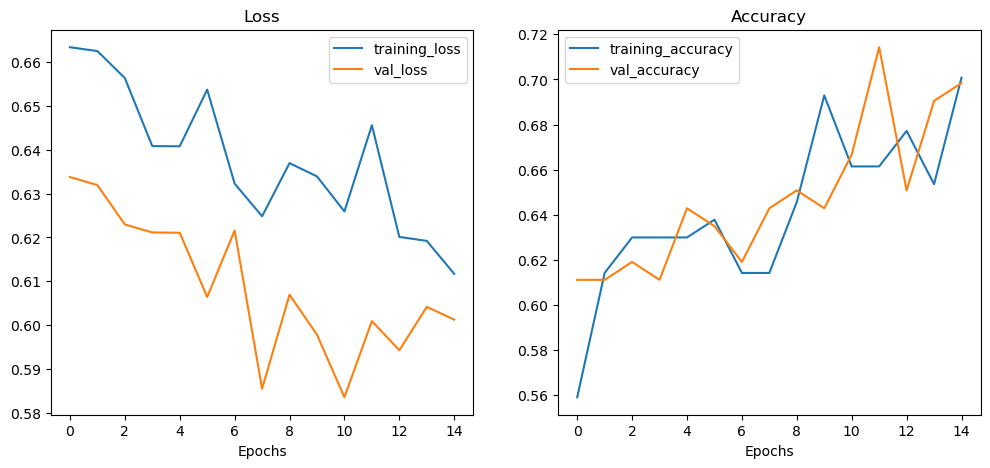

In [14]:
# Function to plot loss and accuracy curves side by side
def plot_curves(history):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    epochs = range(len(history.history["loss"]))
    
    # Create subplots
    plt.figure(figsize=(12, 5))
    
    # Plot loss curves
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="training_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy curves
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="training_accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()
    plt.show()

# Call the function to plot the curves
plot_curves(history)


## Model Result

In [15]:
result = model.evaluate(test_data, verbose=0)
print(f"Accuracy on Evaluation: {result[1]*100:.2f}%\nLoss: {result[0]:.4f}")

Accuracy on Evaluation: 69.05%
Loss: 0.5938


## Confusion Matrix

4/4 [==============================] - 2s 425ms/step


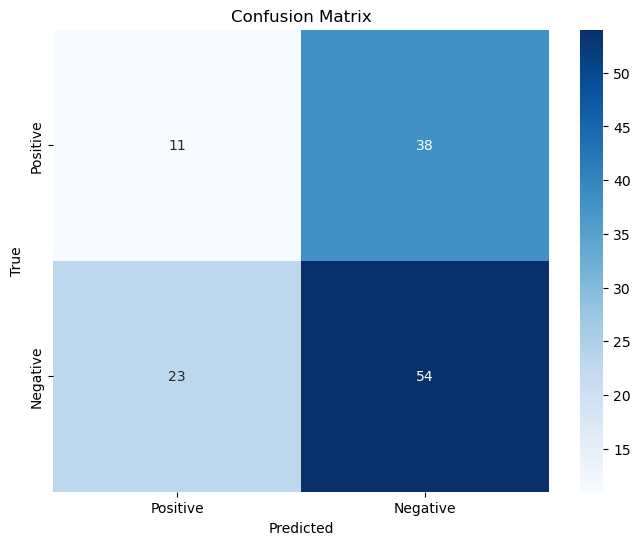

In [16]:
predicted_labels = model.predict(test_data)  

# Convert predicted probabilities to binary class labels (0 or 1)
predicted_labels_binary = np.where(predicted_labels > 0.5, 1, 0)

#  'true_labels' for the test data
true_labels = test_data.labels  

# Calculate the confusion matrix
confusion = confusion_matrix(true_labels, predicted_labels_binary)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Positive', 'Negative'], yticklabels=['Positive', 'Negative'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


## Transfer Learning with EfficientNetB0

In [17]:
# EfficientNetB0 Feature Vector
effnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

# Feature Layer
effnet_layer = hub.KerasLayer(effnet_url,
                              trainable=False,
                              name="feature_extraction_layer")

# Create Sequential model
effnet_model = Sequential([
    effnet_layer,
    Dense(1, activation="sigmoid")
])

# Compile the model
effnet_model.compile(loss=BinaryCrossentropy(),
                     optimizer=Adam(),
                     metrics=["accuracy"])

# Fit the model
effnet_history = effnet_model.fit(train_data,
                                  epochs=epochs,
                                  steps_per_epoch=len(train_data),
                                  validation_data=test_data,
                                  validation_steps=len(test_data))

Epoch 1/15
4/4 [==============================] - 18s 2s/step - loss: 0.6597 - accuracy: 0.5827 - val_loss: 0.5823 - val_accuracy: 0.6905
Epoch 2/15
4/4 [==============================] - 5s 1s/step - loss: 0.6077 - accuracy: 0.6535 - val_loss: 0.5688 - val_accuracy: 0.6905
Epoch 3/15
4/4 [==============================] - 5s 1s/step - loss: 0.5609 - accuracy: 0.7087 - val_loss: 0.5081 - val_accuracy: 0.8254
Epoch 4/15
4/4 [==============================] - 6s 2s/step - loss: 0.5373 - accuracy: 0.7795 - val_loss: 0.4903 - val_accuracy: 0.8333
Epoch 5/15
4/4 [==============================] - 6s 2s/step - loss: 0.5147 - accuracy: 0.8268 - val_loss: 0.4644 - val_accuracy: 0.8492
Epoch 6/15
4/4 [==============================] - 6s 2s/step - loss: 0.5067 - accuracy: 0.8110 - val_loss: 0.4765 - val_accuracy: 0.8016
Epoch 7/15
4/4 [==============================] - 6s 2s/step - loss: 0.4666 - accuracy: 0.8031 - val_loss: 0.4348 - val_accuracy: 0.8492
Epoch 8/15
4/4 [========================

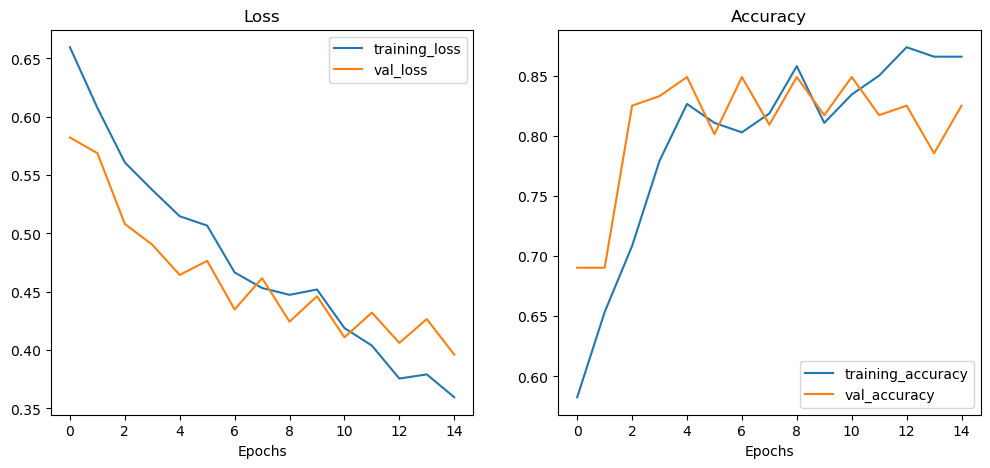

In [18]:
plot_curves(effnet_history)

## Model Result

In [19]:
result = effnet_model.evaluate(test_data, verbose=0)
print(f"Accuracy on Evaluation: {result[1]*100:.2f}%\nLoss: {result[0]:.4f}")

Accuracy on Evaluation: 87.30%
Loss: 0.3661


## Brain Tumor Detection

1/1 [==============================] - 0s 349ms/step


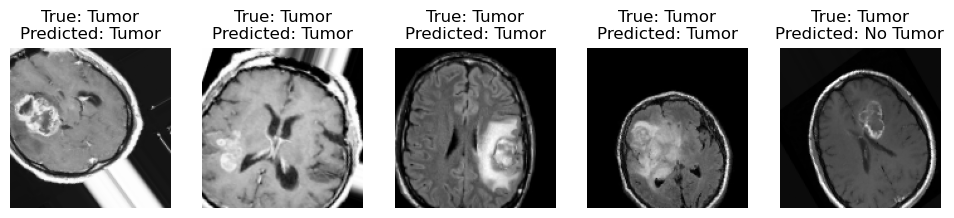

In [21]:
# Function to display images and their predicted labels
def plot_images(images, labels, predicted_labels):
    plt.figure(figsize=(12, 8))
    for i in range(5):  # Plot 10 random images
        index = random.randint(0, len(images) - 1)
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[index])
        true_label = "Tumor" if labels[index] == 1 else "No Tumor"
        predicted_label = "Tumor" if predicted_labels[index] >= 0.5 else "No Tumor"
        plt.title(f'True: {true_label}\nPredicted: {predicted_label}')
        plt.axis('off')

# Get a batch of test data
test_images, test_labels = next(test_data)

# Make predictions
predicted_labels = effnet_model.predict(test_images)

# Plot the random sample of 10 test images
plot_images(test_images, test_labels, predicted_labels)

plt.show()
